In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
%matplotlib inline
import matplotlib.pyplot as plt
from rtree import index

#import models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
# import lightgbm as lgb
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF
#from xgboost import XGBRegressor

from sklearn import model_selection
from sklearn.metrics import explained_variance_score
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from tabulate import _table_formats, tabulate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import pygad
import time
import datetime

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend
import mkl
mkl.set_num_threads(4)

import shap

In [2]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter

In [3]:
datas = './MyData.xlsx'

In [4]:
pd.set_option("display.max_columns", None)
df=pd.read_excel(datas)
df.head(2)
df['logD'] = np.log10(df['diffusivity'])

In [5]:
df2=df[[ 'type', 'gas', 'aperture', 'MetalNum', 'MetalMass', 'size - van der Waals (Å)','mass', 'ascentricF', 'logD', 'size - kinetic diameter (Å)', 'ionicRad', 
       'Μ-N_lff', 'Μ-N_kFF', 'MetalCharge',
       'apertureAtom_σ', 'apertureAtom_e', 'linker_length1', 'linker_length2',
       'linker_length3', 'linker_mass1', 'linker_mass2', 'linker_mass3',
       'func1_length', 'func2_length', 'func3_length', 'func1_mass',  
       'func2_mass', 'func3_mass', 'func1_charge', 'func2_charge',
       'func3_charge',]]

In [6]:
df2=df2.rename(columns={'size - van der Waals (Å)':'diameter', 'size - kinetic diameter (Å)':'kdiameter', 'apertureAtom_e':'e' })

In [7]:
df2 = df2.dropna()
df2=df2.reset_index(drop=True)
# df2

In [8]:
df2=df2[
(df2['gas'] != 'isobutane') & (df2['gas'] != 'iso-butane')
& (df2['gas'] != 'SF6')
# & (df2['gas'] != 'He')
# & (df2['gas'] != 'H2')
# & (df2['gas'] != 'Rn')
].reset_index()

In [9]:
PE_conditions = [
    (df2['gas']=='He'),
    (df2['gas']=='H2'),
    (df2['gas']=='O2'),
    (df2['gas']=='CO2'),
    (df2['gas']=='NO2'),
    (df2['gas']=='N2'),
    (df2['gas']=='CH4'),
    (df2['gas']=='ethylene'),
    (df2['gas']=='ethane'),
    (df2['gas']=='SO2'),
    (df2['gas']=='propylene'),
    (df2['gas']=='propane'),
    (df2['gas']=='butane'),
    (df2['gas']=='Kr'),
    (df2['gas']=='Xe'),
    (df2['gas']=='Rn')]

vertical_values = [0.132, 0.148, 0.151, 0.13785, 0.35551, 0.1655,0.1865,0.18375,0.1875, 0.40354, 0.45134,0.46887,0.46887,0.1845,0.205,0.2085]
long_values = [0.132,0.148,0.423,0.67315, 0.67611, 0.441,0.373, 0.5005,0.529, 0.72906, 0.805922757,0.830810535,1.354965802,0.369,0.41,0.417,]

df2['vertical'] = np.select(PE_conditions, vertical_values)
df2['long'] = np.select(PE_conditions, long_values)

df2

,index,type,gas,aperture,MetalNum,MetalMass,diameter,mass,ascentricF,logD,kdiameter,ionicRad,Μ-N_lff,Μ-N_kFF,MetalCharge,apertureAtom_σ,e,linker_length1,linker_length2,linker_length3,linker_mass1,linker_mass2,linker_mass3,func1_length,func2_length,func3_length,func1_mass,func2_mass,func3_mass,func1_charge,func2_charge,func3_charge,vertical,long
0,0,CdIF-1,He,3.92,48,112.411,2.66,4.002,-0.390,-7.221849,2.60,92,2.257,45354.60,1.1901,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001,0.13200,0.132000
1,1,CdIF-1,H2,3.92,48,112.411,2.76,2.010,-0.217,-7.301030,2.89,92,2.257,45354.60,1.1901,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001,0.14800,0.148000
2,2,CdIF-1,O2,3.92,48,112.411,2.94,31.999,0.022,-8.000000,3.46,92,2.257,45354.60,1.1901,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001,0.15100,0.423000
3,3,CdIF-1,CO2,3.92,48,112.411,3.24,44.010,0.225,-8.397940,3.30,92,2.257,45354.60,1.1901,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001,0.13785,0.673150
4,4,CdIF-1,N2,3.92,48,112.411,3.13,28.000,0.037,-8.301030,3.64,92,2.257,45354.60,1.1901,0.250,0.0627,4.438,4.438,4.438,81.0,81.0,81.0,3.78,3.78,3.78,15.0,15.0,15.0,-0.1001,-0.1001,-0.1001,0.16550,0.441000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,961,dIm_Mg,propylene,2.95,12,24.305,4.03,42.080,0.142,-13.853872,4.50,71,2.139,38994.88,1.9871,0.367,1.2552,6.410,6.410,6.410,317.8,317.8,317.8,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710,0.45134,0.805923
952,962,dIm_Mg,propane,2.95,12,24.305,4.16,44.100,0.152,-17.397940,4.30,71,2.139,38994.88,1.9871,0.367,1.2552,6.410,6.410,6.410,317.8,317.8,317.8,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710,0.46887,0.830811
953,963,dIm_Mg,Kr,2.95,12,24.305,4.00,83.800,0.005,-11.308919,3.69,71,2.139,38994.88,1.9871,0.367,1.2552,6.410,6.410,6.410,317.8,317.8,317.8,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710,0.18450,0.369000
954,964,dIm_Mg,Xe,2.95,12,24.305,4.10,131.290,0.008,-15.924453,4.10,71,2.139,38994.88,1.9871,0.367,1.2552,6.410,6.410,6.410,317.8,317.8,317.8,3.78,3.78,3.78,15.0,15.0,15.0,-0.2710,-0.2710,-0.2710,0.20500,0.410000


In [10]:
x = df2[['diameter',
    'mass',
    'ascentricF',
    'kdiameter',
    'ionicRad',
    'MetalNum',
    'MetalMass',
    'apertureAtom_σ',
    'e',
    'long',
    'vertical',
    'linker_length1', 'linker_length2', 'linker_length3',
    'linker_mass1', 'linker_mass2', 'linker_mass3',
    'func1_length', 'func2_length', 'func3_length', 
    'func1_mass', 'func2_mass', 'func3_mass']]

y= df2[['logD']]

In [11]:
XGBR = XGBRegressor(n_estimators=500, max_depth=5, eta=0.07, subsample=0.75, colsample_bytree=0.7, reg_lambda=0.4, reg_alpha=0.13,
                    # n_jobs=6,
                    nthread=6,
                    random_state=6410
                   )
GBR = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=10,loss='squared_error')

# RF = RandomForestRegressor(n_estimators=600, max_depth=6, random_state=10)

model = XGBR.fit(x,y)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


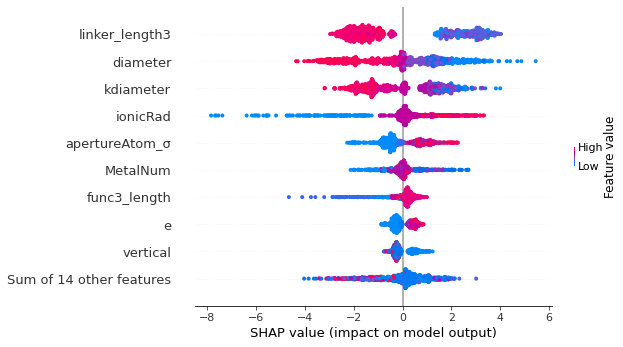

In [12]:
# explainer = shap.TreeExplainer(model)
explainer = shap.explainers.Tree(model)
# explainer = shap.Explainer(model)
shap_values = explainer.shap_values(x)
shap_obj = explainer(x)
shap.plots.beeswarm(shap_obj)

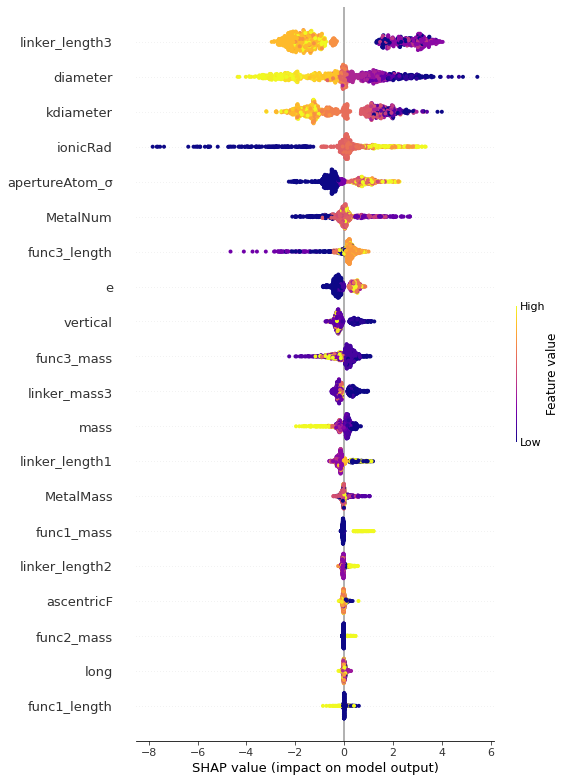

In [13]:
# shap.summary_plot(shap_values)
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, x, cmap="plasma", show="False", plot_size=0.6)
# plt.gcf().axes[-1].set_aspect(10)
# plt.gcf().axes[-1].set_box_aspect(10)


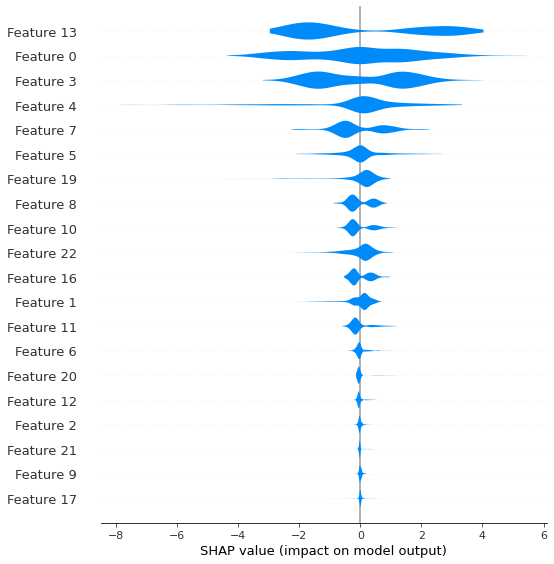

In [14]:
shap.summary_plot(shap_values, plot_type='violin')

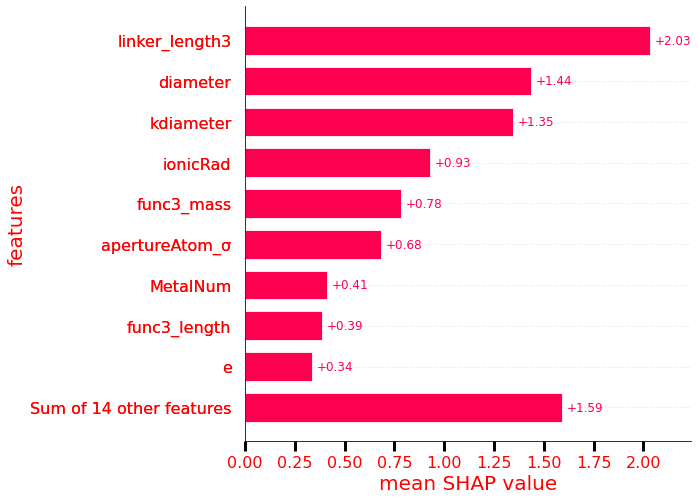

In [15]:
fig = plt.figure()

shap.plots.bar(shap_obj, show=False)
plt.gcf().set_size_inches(8,8)
plt.xlabel('mean SHAP value', fontsize=20, c='r')
plt.ylabel('features',fontsize=20, c='r')

plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
# plt.tick_params(which='major', length=4, color='m')
# plt.tick_params(which='minor', length=4, color='m')
plt.rcParams["figure.figsize"] = (6,6)
# plt.xscale('log')
# plt.yscale('log')
# plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

plt.yticks(fontsize=16, c='r')
plt.xticks(fontsize=16, c='r')


plt.savefig('mean_shap_importance.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

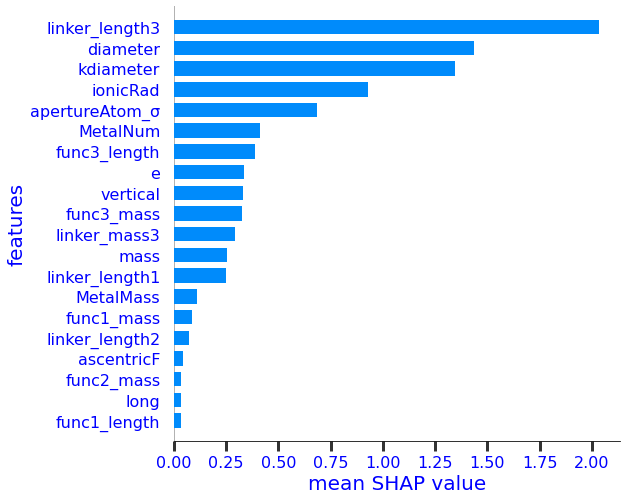

In [25]:
fig = plt.figure()

shap.summary_plot(shap_values, x, plot_type='bar', show=False)
plt.gcf().set_size_inches(8,8)
plt.xlabel('mean SHAP value', fontsize=20, c='b')
plt.ylabel('features',fontsize=20, c='b')

plt.tick_params(which='both', width=3)
plt.tick_params(which='major', length=10)
# plt.tick_params(which='major', length=4, color='m')
# plt.tick_params(which='minor', length=4, color='m')
plt.rcParams["figure.figsize"] = (6,6)
# plt.xscale('log')
# plt.yscale('log')
# plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

plt.yticks(fontsize=16, c='b')
plt.xticks(fontsize=16, c='b')


plt.savefig('shap_importance.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [17]:
shap.plots.force(explainer.expected_value, shap_values[0:100], x)

In [16]:
# import shap
print(shap.__version__)

0.40.0
